In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from PIL import Image

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="PIL")

# Set OpenCV environment variable to suppress warnings
os.environ["OPENCV_IO_PNG_COMPRESSION"] = "0"

# Increase the limit for image size (in pixels) to handle large images
Image.MAX_IMAGE_PIXELS = 300000000

# Define data paths 
- Since each folder under img_highres represents a different type of clothing, we’ll iterate through them to load images and use the folder names as labels.

In [2]:
# Define the path to the high-resolution images directory
base_dir = '../data/Category_and_Attribute_Prediction_Benchmark'
img_dir = os.path.join(base_dir, 'Img', 'img_highres')
anno_fine_dir = os.path.join(base_dir, 'Anno_fine')

# Load train, validation, and test splits
train_split = pd.read_csv(os.path.join(anno_fine_dir, 'train.txt'), sep='\s+', header=None, names=['image_name'])
val_split = pd.read_csv(os.path.join(anno_fine_dir, 'val.txt'), sep='\s+', header=None, names=['image_name'])
test_split = pd.read_csv(os.path.join(anno_fine_dir, 'test.txt'), sep='\s+', header=None, names=['image_name'])

# Load category labels for each split
train_categories = pd.read_csv(os.path.join(anno_fine_dir, 'train_cate.txt'), sep='\s+', header=None, names=['category'])
val_categories = pd.read_csv(os.path.join(anno_fine_dir, 'val_cate.txt'), sep='\s+', header=None, names=['category'])
test_categories = pd.read_csv(os.path.join(anno_fine_dir, 'test_cate.txt'), sep='\s+', header=None, names=['category'])

# Merge splits with their labels to create full train_data, val_data, and test_data
train_data = train_split.join(train_categories)
val_data = val_split.join(val_categories)
test_data = test_split.join(test_categories)

# Define the fraction of the dataset to use for a smaller subset
sample_fraction = 0.4  # 40% of the dataset

# Sample the dataframes for train, validation, and test sets
train_data_subset = train_data.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)
val_data_subset = val_data.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)
test_data_subset = test_data.sample(frac=sample_fraction, random_state=42).reset_index(drop=True)

# Clean up the 'image_name' column paths for the subset
train_data_subset['image_name'] = train_data_subset['image_name'].str.replace('img/', '', regex=False)
val_data_subset['image_name'] = val_data_subset['image_name'].str.replace('img/', '', regex=False)
test_data_subset['image_name'] = test_data_subset['image_name'].str.replace('img/', '', regex=False)

# Print sample data to verify
print("Sample training data subset:")
print(train_data_subset.head())
print(f"Training subset size: {len(train_data_subset)}")
print(f"Validation subset size: {len(val_data_subset)}")
print(f"Test subset size: {len(test_data_subset)}")

Sample training data subset:
                                          image_name  category
0                Pleated_Maxi_Skirt/img_00000066.jpg        33
1  Colorblocked_Tribal_Print_Blouse/img_00000003.jpg         3
2                 Lace_V-Back_Dress/img_00000031.jpg        41
3  Watercolor_Abstract_Print_Blouse/img_00000054.jpg         3
4          Low-Back_Halter_Jumpsuit/img_00000049.jpg        42
Training subset size: 5600
Validation subset size: 800
Test subset size: 1600


# Load Images and Assign Category Labels
- explain here why target_size of 100,100 was used

In [3]:
data = []
labels = []

# Specify target image size for resizing
target_size = (100, 100)

def load_images(data_subset, img_dir, target_size=(100, 100)):
    images = []
    labels = []
    for _, row in data_subset.iterrows():
        img_path = os.path.join(img_dir, row['image_name'])
        label = row['category']
        
        try:
            # Load the image with PIL and convert it to RGB format
            img = Image.open(img_path).convert("RGB")
            img = img.resize(target_size)
            img = np.array(img) / 255.0  # Normalize to [0, 1]
            
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    return np.array(images), np.array(labels)

# Load each dataset split using the sampled subsets
train_images, train_labels = load_images(train_data_subset, img_dir)
val_images, val_labels = load_images(val_data_subset, img_dir)
test_images, test_labels = load_images(test_data_subset, img_dir)

# Print the sizes to verify
print(f"Training images: {train_images.shape}")
print(f"Validation images: {val_images.shape}")
print(f"Test images: {test_images.shape}")

Training images: (5600, 100, 100, 3)
Validation images: (800, 100, 100, 3)
Test images: (1600, 100, 100, 3)


# Additional Evaluation Metrics 
1. NDCG (Normalized Discounted Cumulative Gain)
2. MRR (Mean Reciprocal Rank) 

In [4]:
def dcg_at_k(r, k):
    """Compute DCG@K"""
    r = np.asfarray(r)[:k]
    if r.size:
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    return 0.0

def ndcg_at_k(y_true, y_pred, k):
    """Compute NDCG@K"""
    ideal_r = sorted(y_true, reverse=True)
    dcg = dcg_at_k(y_true, k)
    idcg = dcg_at_k(ideal_r, k)
    return dcg / idcg if idcg > 0 else 0

def mean_reciprocal_rank(y_true, y_pred):
    """Compute MRR"""
    ranks = []
    for true, pred in zip(y_true, y_pred):
        sorted_pred = np.argsort(pred)[::-1]
        rank = np.where(sorted_pred == np.argmax(true))[0][0] + 1
        ranks.append(1 / rank)
    return np.mean(ranks)


# Preprocess and Prepare the Data for Training
- Convert labels to categorical format if they’re not already (e.g., one-hot encoding).
- Augment the dataset if necessary, using data augmentation techniques to improve model generalization.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

# Combine all categories into one DataFrame to get unique categories across all splits
all_categories = pd.concat([train_categories, val_categories, test_categories], ignore_index=True)

# Define constants
# Set parameters according to the table
TARGET_SIZE = (100, 100)  # Pixel density
BATCH_SIZE = 64           # Batch size
NUM_CLASSES = 49          
EPOCHS = 100               # You can increase to 100 based on resources
VALIDATION_SPLIT = 0.2

# Load the sampled data subsets as numpy arrays
train_images, train_labels = load_images(train_data_subset, img_dir, target_size=TARGET_SIZE)
val_images, val_labels = load_images(val_data_subset, img_dir, target_size=TARGET_SIZE)

# Convert labels to categorical format
train_labels = to_categorical(train_labels, num_classes=NUM_CLASSES)
val_labels = to_categorical(val_labels, num_classes=NUM_CLASSES)

# Create TensorFlow datasets from the numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

# Shuffle, batch, and prefetch the datasets
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Define the Xception model with custom layers for classification
base_model = Xception(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
base_model.trainable = False  # Freeze the base model layers

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Unfreeze some layers in the base model
for layer in base_model.layers[-30:]:  # Experiment with how many layers to unfreeze
    layer.trainable = True

# Re-compile the model with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Continue training
history = model.fit(train_dataset, validation_data=val_dataset, epochs=EPOCHS)

# Optionally evaluate on the test set if you have a subset prepared
test_images, test_labels = load_images(test_data_subset, img_dir, target_size=TARGET_SIZE)
test_labels = to_categorical(test_labels, num_classes=NUM_CLASSES)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE)

test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy}")


## Adding L2 regularization + drop out 
The earlier model has been overfitted: The training accuracy is very high (99.9%), and the training loss is extremely low (~0.0037). This indicates the model has memorized the training data. Validation accuracy is significantly lower (45%), and validation loss is increasing. This indicates that the model does not generalize well to unseen data.Testing accuracy is not improving significantly, aligning with the validation results, and the test loss remains relatively high.

In [4]:
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

# Combine all categories into one DataFrame to get unique categories across all splits
all_categories = pd.concat([train_categories, val_categories, test_categories], ignore_index=True)

# Define constants
# Set parameters according to the table
TARGET_SIZE = (100, 100)  # Pixel density
BATCH_SIZE = 64           # Batch size
NUM_CLASSES = 49          
EPOCHS = 100               # You can increase to 100 based on resources
VALIDATION_SPLIT = 0.2

# Load the sampled data subsets as numpy arrays
train_images, train_labels = load_images(train_data_subset, img_dir, target_size=TARGET_SIZE)
val_images, val_labels = load_images(val_data_subset, img_dir, target_size=TARGET_SIZE)

# Convert labels to categorical format
train_labels = to_categorical(train_labels, num_classes=NUM_CLASSES)
val_labels = to_categorical(val_labels, num_classes=NUM_CLASSES)

# Create TensorFlow datasets from the numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

# Shuffle, batch, and prefetch the datasets
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Define the Xception model with L2 Regularization and Dropout
base_model = Xception(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
base_model.trainable = False  # Initially freeze the base model layers

# Add custom layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(1e-4))(x)  # L2 Regularization
x = Dropout(0.5)(x)  # Dropout to prevent overfitting
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=l2(1e-4))(x)  # Output layer with L2

# Define the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Initial training with frozen layers
history = model.fit(train_dataset, validation_data=val_dataset, epochs=20)

# Fine-tune the model by unfreezing some base model layers
for layer in base_model.layers[-50:]:  # Unfreeze the last 30 layers (experiment with this value)
    layer.trainable = True

# Re-compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
fine_tuning_history = model.fit(train_dataset, validation_data=val_dataset, epochs=80, initial_epoch=20)

test_images, test_labels = load_images(test_data_subset, img_dir, target_size=TARGET_SIZE)
test_labels = to_categorical(test_labels, num_classes=NUM_CLASSES)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE)

test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy}")

/Users/dalenlim/cs310/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
2024-11-22 13:20:56.415913: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-11-22 13:20:56.418529: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-11-22 13:20:56.420940: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-11-22 13:20:56.428660: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-22 13:20:56.433690: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB mem

Epoch 1/20


2024-11-22 13:21:03.329314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 271ms/step - accuracy: 0.2518 - loss: 3.2907 - val_accuracy: 0.3925 - val_loss: 2.4864
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 245ms/step - accuracy: 0.3787 - loss: 2.5102 - val_accuracy: 0.4087 - val_loss: 2.3471
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 249ms/step - accuracy: 0.4145 - loss: 2.3172 - val_accuracy: 0.4300 - val_loss: 2.2741
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 236ms/step - accuracy: 0.4327 - loss: 2.2003 - val_accuracy: 0.4363 - val_loss: 2.2328
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 23s 257ms/step - accuracy: 0.4581 - loss: 2.0710 - val_accuracy: 0.4425 - val_loss: 2.2107
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.4862 - loss: 1.9690 - val_accuracy: 0.4462 - val_loss: 2.1839
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 235ms/step - accuracy: 0.5017 - loss: 1.9015 - val_accuracy: 0.4425 - val_loss: 2.1682
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 238ms/step - accuracy: 0.5130 - loss: 1.8356 - val_accuracy: 0.446

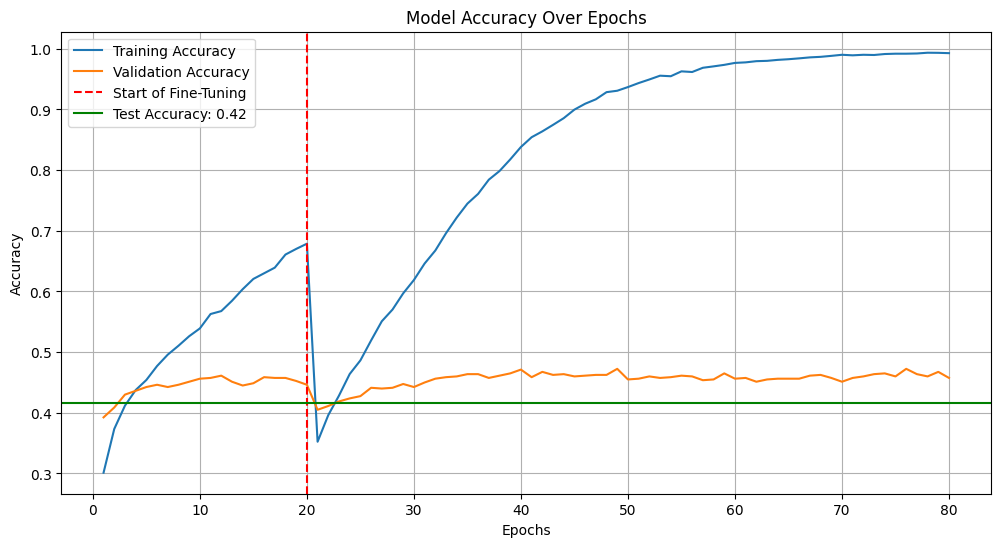

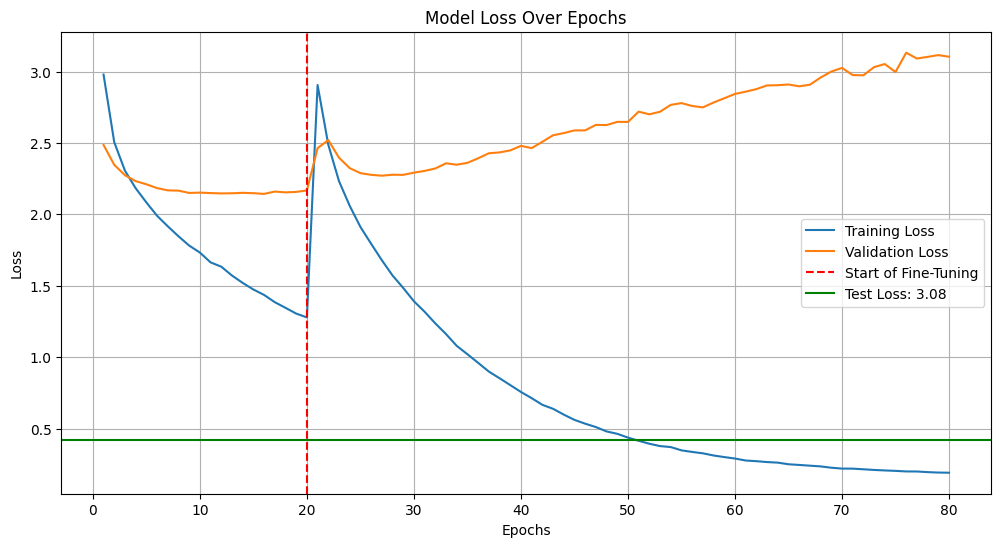

In [10]:
import matplotlib.pyplot as plt

# Extract metrics from the history objects
initial_epochs = 20
total_epochs = 80

train_accuracy = history.history['accuracy'] + fine_tuning_history.history['accuracy']
val_accuracy = history.history['val_accuracy'] + fine_tuning_history.history['val_accuracy']

train_loss = history.history['loss'] + fine_tuning_history.history['loss']
val_loss = history.history['val_loss'] + fine_tuning_history.history['val_loss']

# Prepare the data
epochs = list(range(1, total_epochs + 1))

# Plot accuracy
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.axvline(x=initial_epochs, color='r', linestyle='--', label='Start of Fine-Tuning')
plt.axhline(y=test_accuracy, color='g', linestyle='-', label=f'Test Accuracy: {test_accuracy:.2f}')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot loss
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.axvline(x=initial_epochs, color='r', linestyle='--', label='Start of Fine-Tuning')
plt.axhline(y=test_accuracy, color='g', linestyle='-', label=f'Test Loss: {test_loss:.2f}')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [1]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Predict function
def predict_image(image_path, model):
    image = load_img(image_path, target_size=(100, 100))
    image = img_to_array(image) / 255.0
    image = image.reshape(1, 100, 100, 3)
    prediction = model.predict(image)
    predicted_class = list(train_dataset.class_indices.keys())[np.argmax(prediction)]
    return predicted_class

# Visualize predictions
for i, row in val_dataset.sample(5).iterrows():
    img_path = '../data/Category_and_Attribute_Prediction_Benchmark/Img/' + row['image_name']
    plt.imshow(load_img(img_path))
    plt.title(f"Predicted: {predict_image(img_path, model)}")
    plt.show()

/Users/dalenlim/cs310/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


NameError: name 'val_df' is not defined

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Set parameters according to the table
TARGET_SIZE = (100, 100)  # Pixel density
BATCH_SIZE = 64           # Batch size
NUM_CLASSES = 49          
EPOCHS = 100               # You can increase to 100 based on resources
VALIDATION_SPLIT = 0.2

# Combine all categories into one DataFrame to get unique categories across all splits
all_categories = pd.concat([train_categories, val_categories, test_categories], ignore_index=True)

# Load the sampled data subsets as numpy arrays
train_images, train_labels = load_images(train_data_subset, img_dir, target_size=TARGET_SIZE)
val_images, val_labels = load_images(val_data_subset, img_dir, target_size=TARGET_SIZE)

# Convert labels to categorical format
train_labels = to_categorical(train_labels, num_classes=NUM_CLASSES)
val_labels = to_categorical(val_labels, num_classes=NUM_CLASSES)

# Create TensorFlow datasets from the numpy arrays
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))

# Shuffle, batch, and prefetch the datasets
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

# Define the data augmentation pipeline
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,
    rotation_range=40,         # Rotate images up to 40 degrees
    width_shift_range=0.3,     # Shift width up to 30% of image width
    height_shift_range=0.3,    # Shift height up to 30% of image height
    shear_range=0.3,           # Shearing transformations
    zoom_range=0.3,            # Random zooming in/out
    horizontal_flip=True,      # Flip images horizontally
    fill_mode='nearest'        # Fill missing pixels with nearest value
)

# Define validation and test data generators (only normalization)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Apply data augmentation to the training data
train_generator = train_datagen.flow(
    x=train_images,
    y=train_labels,
    batch_size=BATCH_SIZE
)

# Apply normalization to validation and test data
val_generator = val_datagen.flow(
    x=val_images,
    y=val_labels,
    batch_size=BATCH_SIZE
)

test_generator = test_datagen.flow(
    x=test_images,
    y=test_labels,
    batch_size=BATCH_SIZE
)


# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',        # Monitors validation loss
    patience=10,               # Stops if val_loss doesn't improve for 10 epochs
    restore_best_weights=True  # Restores the model weights with the lowest val_loss
)

# Define the Xception model with regularization and dropout
base_model = Xception(weights='imagenet', include_top=False, input_shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3))
base_model.trainable = False  # Freeze base model layers

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(1e-4))(x)  # L2 Regularization
x = Dropout(0.5)(x)  # Dropout layer
predictions = Dense(NUM_CLASSES, activation='softmax', kernel_regularizer=l2(1e-4))(x)

# Compile the full model
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train with augmented data
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stopping]
)

# Fine-tune by unfreezing the last two blocks of the base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Re-compile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tune the model
fine_tuning_history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=80,
    initial_epoch=20,
    callbacks=[early_stopping]
)

/Users/dalenlim/cs310/venv/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


2024-11-18 17:05:21.634323: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


88/88 ━━━━━━━━━━━━━━━━━━━━ 27s 274ms/step - accuracy: 0.2103 - loss: 3.9307 - val_accuracy: 0.2988 - val_loss: 3.5400
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 241ms/step - accuracy: 0.2784 - loss: 3.3878 - val_accuracy: 0.2988 - val_loss: 2.9344
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 237ms/step - accuracy: 0.2737 - loss: 2.8978 - val_accuracy: 0.2988 - val_loss: 2.7555
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 245ms/step - accuracy: 0.2684 - loss: 2.8170 - val_accuracy: 0.2988 - val_loss: 2.7174
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 246ms/step - accuracy: 0.2743 - loss: 2.7819 - val_accuracy: 0.2988 - val_loss: 2.7011
Epoch 6/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 22s 247ms/step - accuracy: 0.2818 - loss: 2.7309 - val_accuracy: 0.2988 - val_loss: 2.6926
Epoch 7/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 240ms/step - accuracy: 0.2787 - loss: 2.7397 - val_accuracy: 0.2988 - val_loss: 2.6874
Epoch 8/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 236ms/step - accuracy: 0.2764 - loss: 2.7349 - val_accuracy: 0.298

## Evaluation

In [9]:
# Optionally evaluate on the test set if you have a subset prepared
test_images, test_labels = load_images(test_data_subset, img_dir, target_size=TARGET_SIZE)
test_labels = to_categorical(test_labels, num_classes=NUM_CLASSES)
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH_SIZE)

test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 244ms/step - accuracy: 0.2752 - loss: 45.6879
Test accuracy: 0.2693749964237213


In [1]:

from sklearn.metrics import accuracy_score

# Get predictions on the validation or test set
y_pred = model.predict(test_dataset)

# Convert predictions to ranks
y_true = np.argmax(test_labels, axis=1)
y_pred_ranks = np.argsort(y_pred, axis=1)[:, ::-1]

# Compute metrics
ndcg_scores = [ndcg_at_k(y_true[i], y_pred[i], k=5) for i in range(len(y_true))]
mrr_score = mean_reciprocal_rank(test_labels, y_pred)

print(f"Accuracy: {accuracy_score(y_true, np.argmax(y_pred, axis=1))}")
print(f"Mean NDCG@5: {np.mean(ndcg_scores)}")
print(f"MRR: {mrr_score}")

NameError: name 'model' is not defined